In [1]:
from bin.transform import four_point_transform
from skimage.filters import threshold_local
import numpy as np
import argparse
import cv2
import imutils
import matplotlib.pyplot as plt

'''for video stramening'''
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils.video import FPS
import time

## Scan Document from web cam

In [2]:
def detect_document(image):
    """
    Extracts tries to extrat the document location
    """
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(gray, 55, 200)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]

    for c in cnts:
        '''approximate the contour'''
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        '''if our approximated contour has four points, then we can assume that we have found our screen'''
        if len(approx) == 4:
            return approx

In [3]:
def scan_from_frame(frame):
    '''
    crops the document from each frame
    '''
    screenCnt = detect_document(frame)
    if not(np.any(screenCnt)):
        return None
    else:
        cv2.drawContours(frame, [screenCnt], -1, (0, 255, 0), 2)
        warped = four_point_transform(frame, screenCnt.reshape(4, 2))
        warped = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
#         T = threshold_local(warped, 11, offset = 10, method = "gaussian")
#         warped = (warped > T).astype("uint8") * 255
        return warped

In [32]:
def scan_on_streaming(n_samples=25):
    """
    This function starts the screaming object;
    And from each frame tries to extract the document scan;
    """
    scans = list()
    
    print('[INFO] Starting video stream...')
    vs = VideoStream(src=0).start()
    time.sleep(2.0)

    '''start the FPS throughput estimator'''
    fps = FPS().start()
    encodings = []
    labelSet = set()


    '''loop over frames from the video file stream'''
    try:
        while True:
            '''grab the frame from the threaded video stream'''
            frame = vs.read()
            frame = imutils.resize(frame, width=500)
#             rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            """SCAN FROM FRAME"""
            scaned = scan_from_frame(frame)
            if np.any(scaned) and len(scans)<n_samples:
                scans += [imutils.resize(scaned, height = 650)]
                    
            '''update the FPS counter'''
            fps.update()
            cv2.imshow("Frame", frame)
            key = cv2.waitKey(1) & 0xFF
            
            '''stop scan'''
            if key == ord("q"): break
                
#     '''Stop Some processes'''
    except: pass 
    finally:
        fps.stop()
        cv2.destroyAllWindows()
        vs.stop()

    '''feed back'''
    print(f'[INFO] elasped time: {fps.elapsed():.2f}')
    print(f'[INFO] approx. FPS: {fps.fps():.2f}')
    return scans

## Colect Scaned Samples

In [42]:
scans = scan_on_streaming() # Colect samples

[INFO] Starting video stream...
[INFO] elasped time: 3.55
[INFO] approx. FPS: 107.95


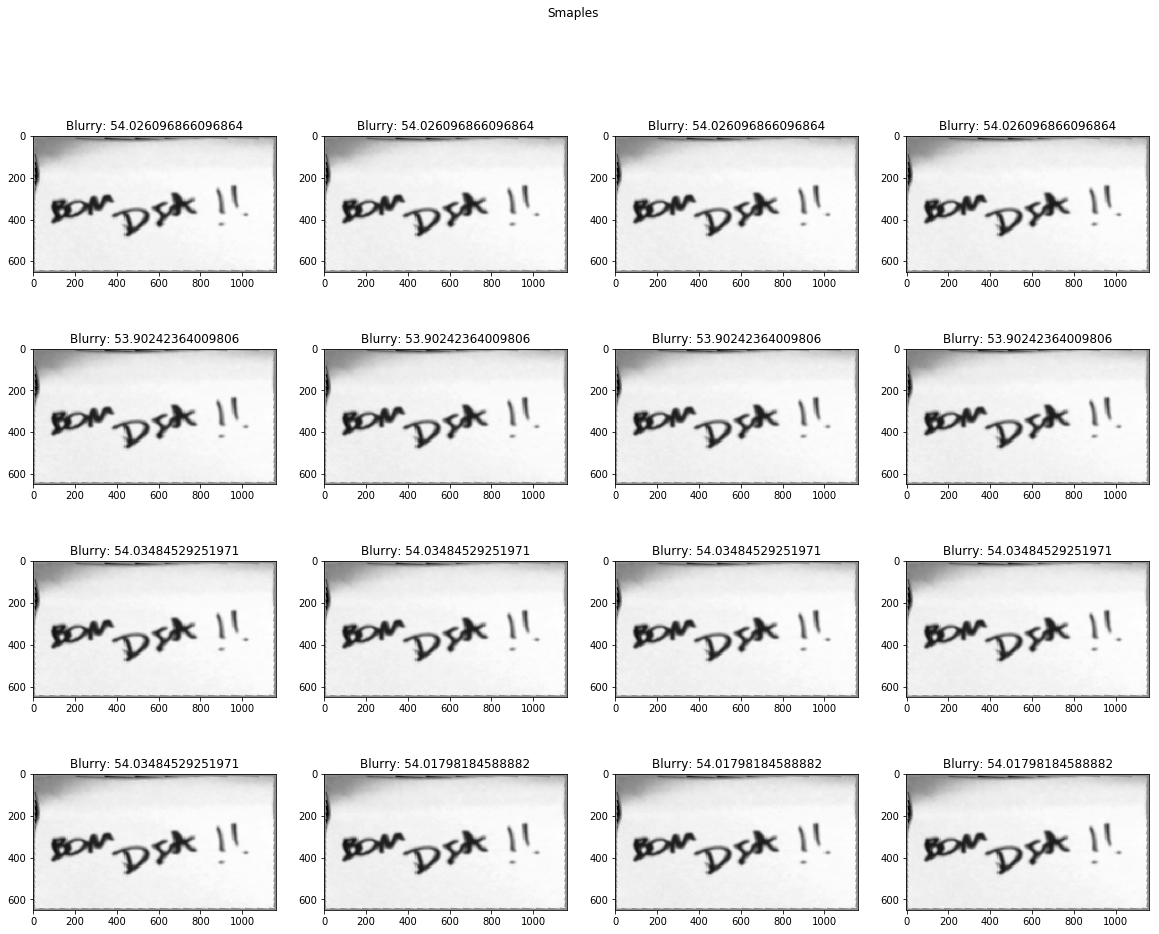

In [46]:
scan_list = scans[:16]

plt.figure(figsize=(20,15))
plt.suptitle('Smaples')
for i,img in enumerate(scan_list):
    try:
        '''calculate how blurry is the scaned sample'''
        blurry = cv2.Laplacian(img, cv2.CV_64F).var()
        
        '''plot'''
        plt.subplot(np.sqrt(len(scan_list)),np.sqrt(len(scan_list)),i+1)
        plt.title(f'Blurry: {blurry}')
        plt.imshow(img, cmap='gray')
    except:
        break
plt.show()

## Find the less blurry image

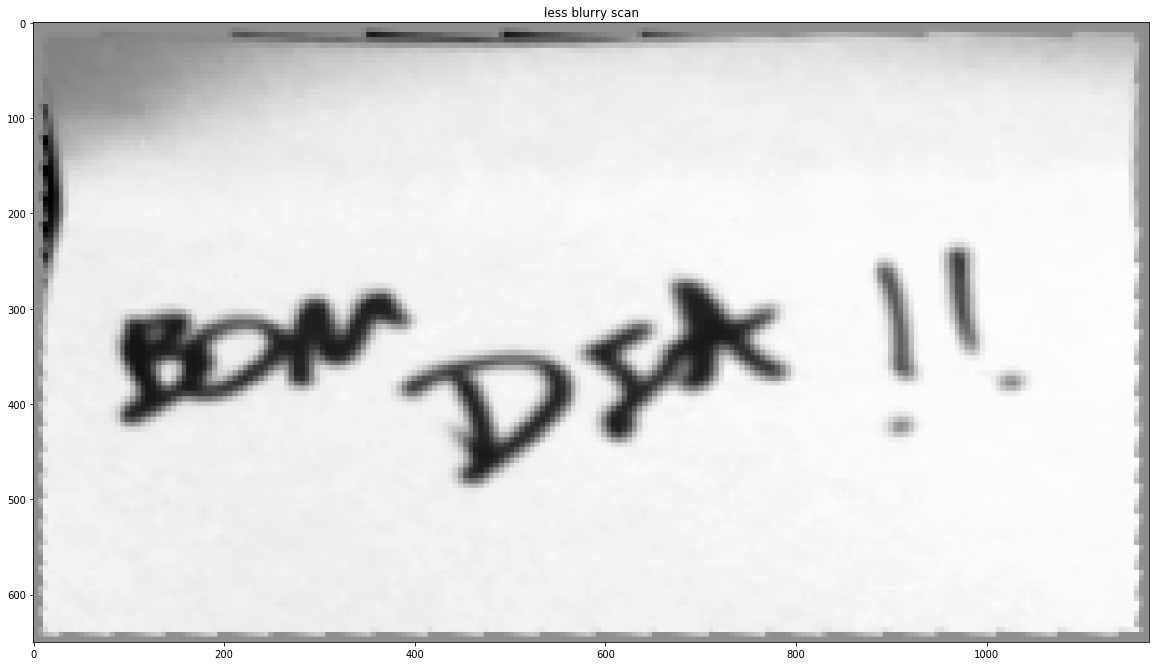

In [48]:
blurry = [cv2.Laplacian(img, cv2.CV_64F).var() for img in scans] 
less_blurry = max(blurry) ## the less blurry image has the max laplacian value
less_blurry_scan = scans[blurry.index(less_blurry)]

plt.figure(figsize=(20,15))
plt.title('less blurry scan')
plt.imshow(less_blurry_scan, cmap='gray')
plt.show()